# Parsing binary data

Starting point: use `remote_rx.py` to save data to a file:

```
python remote_rx.py --address 192.168.1.100 --rate 50000 --freq 1410000
...receiving at: 1410000 Hz sample sample rate: 50000  / correction (ppm): 0
c^Cshutdown
bye
```

I modified the code so that it would save to a file test.raw

In [25]:
import struct
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!ls -s test.raw

3744 test.raw


In [3]:
with open("test.raw", "rb") as f:
    file_contents = f.read()

In [22]:
N = 100
file_contents[0:4*N]

b'\x00\x00,\xb7\x00\x00\xb06\x00\x00P6\x00\x0006\x00\x0047\x00\x00\x88\xb6\x00\x00\x005\x00\x00\xc0\xb5\x00\x00$\xb7\x00\x00\xa06\x00\x00\x88\xb6\x00\x00\x0c\xb7\x00\x00\xe05\x00\x00\xe8\xb6\x00\x00\xd8\xb6\x00\x00\xe0\xb5\x00\x00\x04\xb7\x00\x00\x106\x00\x00,\xb7\x00\x00\x087\x00\x00 \xb6\x00\x00\x005\x00\x00\xc0\xb6\x00\x00 \xb6\x00\x00\x90\xb6\x00\x00\x047\x00\x00\xc0\xb5\x00\x00\x10\xb6\x00\x00P\xb6\x00\x00\x00\xb6\x00\x00\xa86\x00\x00\x047\x00\x00\xa05\x00\x00\x107\x00\x00 6\x00\x00 6\x00\x00\x08\xb7\x00\x00<\xb7\x00\x00\xe05\x00\x00\xa05\x00\x00\x80\xb5\x00\x00\xc05\x00\x00\xd0\xb6\x00\x00\xe8\xb6\x00\x00\x18\xb7\x00\x00\x805\x00\x00\xe0\xb6\x00\x00\xb06\x00\x00\x047\x00\x00\x804\x00\x00\x805\x00\x00\x00\xb6\x00\x00\x10\xb6\x00\x00D7\x00\x00\x107\x00\x00\x00\x00\x00\x00\x007\x00\x00\xd8\xb6\x00\x00\x80\xb6\x00\x00\xf86\x00\x00\x187\x00\x00\x00\xb7\x00\x00\xa06\x00\x00(\xb7\x00\x00\xe0\xb5\x00\x00 \xb6\x00\x00$7\x00\x00\x187\x00\x00\x087\x00\x00\xf86\x00\x00@5\x00\x00\xb8\xb6\x00\

In [23]:
test = np.array(struct.unpack("<100f", file_contents[0:4*N]))

In [26]:
I = test[0::2]
Q = test[1::2]
t = np.array(range(N//2))*1/50e3

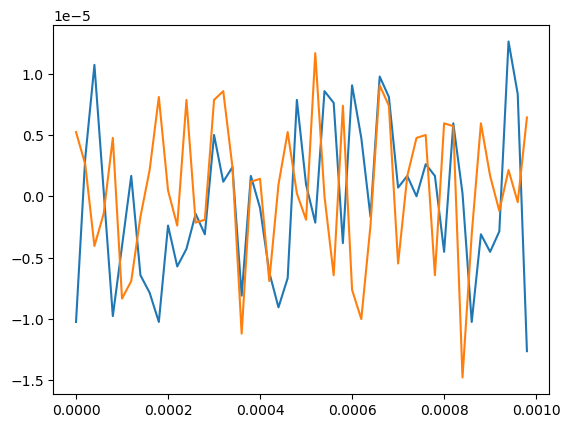

In [27]:
plt.plot(t,I)
plt.plot(t,Q)

Seems reasonable. Now real test is to repeat this while sending in a signal from the WFT close to the demodulation frequency and check that we get a cosine.

# Now load straight from SDR server into python

First, we'll try getting some data in directly into this notebook. Start by adapting verbatim.

In [19]:
import socket, struct, signal, traceback, time
import struct
import numpy as np
import matplotlib.pyplot as plt

N = 1024

rate_index = {20000:0, 50000:1, 100000:2, 250000:3, 500000:4, 1250000:5}
freq = 10e6
rate = 100000
ip = "192.168.1.100"

def get_data():
    control_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    data_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    
    # Both read and write are both on port 1001 (not sure why we use two different sockets...?)
    control_socket.connect((ip, 1001))
    data_socket.connect((ip,1001))
    
    control_socket.send(struct.pack('<I', 0))
    data_socket.send(struct.pack('<I', 1))
    
    # Set freq and rate
    control_socket.send(struct.pack('<I', 0<<28 | int(freq)))
    control_socket.send(struct.pack('<I', 1<<28 | rate_index[rate]))

    bytesRead = 0
    bytesToGo = N*2*4
    while bytesRead < N*2*4:
        try:
            if bytesRead == 0:
                raw_data = data_socket.recv(bytesToGo) # 32 bit = 4 bytes, then x2 for I and Q
            else:
                raw_data += data_socket.recv(bytesToGo) # 32 bit = 4 bytes, then x2 for I and Q
            #print(len(raw_data))
            bytesToGo = N*2*4-len(raw_data)
            bytesRead = len(raw_data)
        except KeyboardInterrupt:
            data_socket.close()
            control_socket.close()
            return "","",""
        except:
            traceback.print_exc()
            data_socket.close()
            control_socket.close()            
                        
    data_socket.close()
    control_socket.close()
    
    Nrecv = len(raw_data)
    Ncomp = (len(raw_data)//4//2)
    
    # print("Requested bytes: %d" % (N*4*2)) 
    # print("Recieved bytes: %d" % Nrecv)
    # print("Requested IQs:  %d" % N)
    # print("Completed IQs:  %d" % Ncomp) 
    
    data = np.array(struct.unpack("<%df" % (Ncomp*2), raw_data))
    I = data[0::2]
    Q = data[1::2]
    t = np.array(range(Ncomp))*1/rate
    return I, Q, t

In [20]:
get_data()

(array([-2.00271606e-05,  2.12192535e-05,  3.14712524e-05, ...,
        -1.31215096e-01, -1.12800121e-01, -9.67721939e-02]),
 array([ 5.48362732e-06,  9.53674316e-06, -1.57356262e-05, ...,
        -1.31851196e-01, -1.48551464e-01, -1.59398079e-01]),
 array([0.000e+00, 1.000e-05, 2.000e-05, ..., 1.021e-02, 1.022e-02,
        1.023e-02]))

In [21]:
import numpy as np

from bokeh.plotting import figure, show
from bokeh.io import output_notebook, push_notebook
output_notebook()
import ipywidgets as widgets

Loading BokehJS ...

In [22]:
I,Q,t = get_data()
p = figure(height=200, width=600) 
p.sizing_mode = "scale_width"
l1 = p.line(t,I,color='blue')
l2 = p.line(t,Q,color='red')
target = show(p, notebook_handle=True)

A hacked live viewer:

In [24]:
print("live view started")
while True:
    try: 
        I,Q,t = get_data()
        if type(I) is not np.ndarray:
            break
        l1.data_source.data = dict(x=t,y=I)
        l2.data_source.data = dict(x=t,y=Q)
        time.sleep(0.1)
        push_notebook(handle=target)
    except KeyboardInterrupt:
        print("done")
        break

live view started


Sometimes a bit flaky, I think bokeh crashes something and then I can no longer get traces from the server. Curiously, I need to reload the browser tab and then it works again, even without restarting the kernel...

In [11]:
import wft

In [2]:
port = "/dev/tty.usbmodem206C34714E561"
wft1 = wft.WFT(port)

In [12]:
wft1.query("f?")

'10.00200000\n'

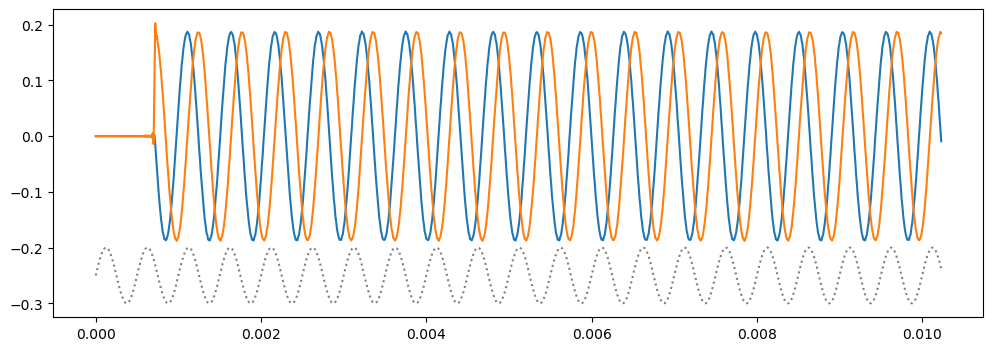

In [33]:
I,Q,t = get_data()
plt.figure(figsize=(12,4))
plt.plot(t,I)
plt.plot(t,Q)
plt.plot(t,np.sin(2*np.pi*2e3*t)*0.05-0.25, c='grey', ls=":")

Confirmed: things work! The IQs oscillate at 2 kHz. Actually, if I look closely, I can see that these are not clocked properly, they are slowly drifting. That is maybe already my need for a clock lock between the RP and the WFT.

How far off? Maybe 20 oscillations to slip? that would be 100 Hz on 10 MHz, 1 part in 10^4. Maybe not unexpected for the absolute accuracy of the RP clock frequency? 

## Figuring out how to get both inputs

Seems to be that you can create a separate set of sockets on port 1002 to get input 2.

In [53]:
import socket, struct, signal, traceback, time

N = 1024

rate_index = {20000:0, 50000:1, 100000:2, 250000:3, 500000:4, 1250000:5}
freq = 10e6
rate = 100000
ip = "192.168.1.100"

def get_data2():
    control_socket1 = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    data_socket1 = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    control_socket2 = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
    data_socket2 = socket.socket(socket.AF_INET, socket.SOCK_STREAM)    

    # Both read and write are both on port 1001 (not sure why we use two different sockets...?)
    control_socket1.connect((ip, 1001))
    data_socket1.connect((ip,1001))

    control_socket2.connect((ip, 1002))
    data_socket2.connect((ip,1002))

    control_socket1.send(struct.pack('<I', 0))
    data_socket1.send(struct.pack('<I', 1))

    control_socket2.send(struct.pack('<I', 0))
    data_socket2.send(struct.pack('<I', 1))

    # Set freq and rate
    control_socket1.send(struct.pack('<I', 0<<28 | int(freq)))
    control_socket1.send(struct.pack('<I', 1<<28 | rate_index[rate]))
    control_socket2.send(struct.pack('<I', 0<<28 | int(freq)))
    control_socket2.send(struct.pack('<I', 1<<28 | rate_index[rate]))


    bytesRead1 = 0
    bytesToGo1 = N*2*4
    bytesRead2 = 0
    bytesToGo2 = N*2*4
    while bytesRead1 < N*2*4 or bytesRead2 < N*2*4:
            if bytesRead1 == 0:
                raw_data1 = data_socket1.recv(bytesToGo1) # 32 bit = 4 bytes, then x2 for I and Q
            elif bytesRead1 < N*2*4:
                raw_data1 += data_socket1.recv(bytesToGo1) # 32 bit = 4 bytes, then x2 for I and Q
            bytesToGo1 = N*2*4-len(raw_data1)
            bytesRead1 = len(raw_data1)

            if bytesRead2 == 0:
                raw_data2 = data_socket2.recv(bytesToGo2) # 32 bit = 4 bytes, then x2 for I and Q
            elif bytesRead2 < N*2*4:
                raw_data2 += data_socket2.recv(bytesToGo2) # 32 bit = 4 bytes, then x2 for I and Q
            #print(len(raw_data))
            bytesToGo2 = N*2*4-len(raw_data2)
            bytesRead2 = len(raw_data2)    

    data_socket1.close()
    control_socket1.close()
    data_socket2.close()
    control_socket2.close()

    data1 = np.array(struct.unpack("<%df" % (N*2), raw_data1))
    I1 = data1[0::2]
    Q1 = data1[1::2]
    data2 = np.array(struct.unpack("<%df" % (N*2), raw_data2))
    I2 = data2[0::2]
    Q2 = data2[1::2]
    t = np.array(range(N))*1/rate
    return I1, Q1, I2, Q2, t

We'll also start to make this notebook into a logbook. 

In [69]:
import datetime
from IPython.display import Image
def save_plot():
    filename = datetime.datetime.now().strftime("%Y_%m_%d_%H.%M.%S")+".png"
    plt.savefig(filename)
    Image(filename)
    print(filename)

In [70]:
I1, Q1, I2, Q2, t = get_data2()
plt.figure(figsize=(12,6))
plt.subplot(211)
plt.plot(t,I1)
plt.plot(t,Q1)
plt.subplot(212)
plt.plot(t,I2)
plt.plot(t,Q2)
save_plot()

2023_11_23_06.47.33.png


OK, data acquisition seems to work!

We see here maybe already a problem: leakage into the other channel. The plot 2023_11_23_06.47.33.png is without the other channel connected. Maybe things will get better if we 50 ohm terminate the RP inputs.

Actually, probably best is to buy one of these, they are 50 ohm terminated already (and 16 bit):

https://redpitaya.com/sdrlab-122-16/

> It comes with two 16-bit 50-ohm inputs and 14-bit 50-ohm outputs, Xilinx Zynq 7020 FPGA for real-time processing capabilities plus an ultra-low phase noise 122.88MHz clock which makes it more hardware-compatible with HPSDR compliant applications. RF inputs are optimized for minimal distortion, noise and crosstalk which significantly improves reception and broadens the choice of antenna.

Yep, for sure. Time to order.

Only thing I'm not 100% sure on is the external clock. I think the problem is going to be that the RPs have no support for a 10 MHz external ref. They do have an external clock input I believe. 

But you need to buy a special version of the board (or manually desolder a bunch of components). And you need to generate the (122 or 125 MHz) clock, I guess derived from the 10 MHz system clock.

Unless I can clock the WFT with a 122 MHz external ref, in which case we should be good. Then I could probably pick up the clock out of RP and use it as ref in on the WFT. But it goes only to 100 MHz...

I guess probably a divide by 2 circuit would work. Hmm.

Or I could just use the RP as the clock using its DDS to generate an output ref on one of the unused outputs. Probalbly best for now. 